In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from celluloid import Camera
from IPython.display import HTML

In [2]:
root = Path("Task03_Liver_rs/imagesTr/")
label = Path("Task03_Liver_rs/labelsTr/")

In [3]:

# A helper function which automatically replaces "imagesTr" with "labelsTr" in the filepaths so that we can easily switch between CT images and label masks
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object

In [4]:
sample_path=list(root.glob("liver*"))[0]
sample_path_label=change_img_to_label_path(sample_path)

In [5]:
ct=nib.load(sample_path).get_fdata()
mask=nib.load(sample_path_label).get_fdata().astype(int)

In [6]:
ct.shape

(176, 176, 196)

<IPython.core.display.Javascript object>


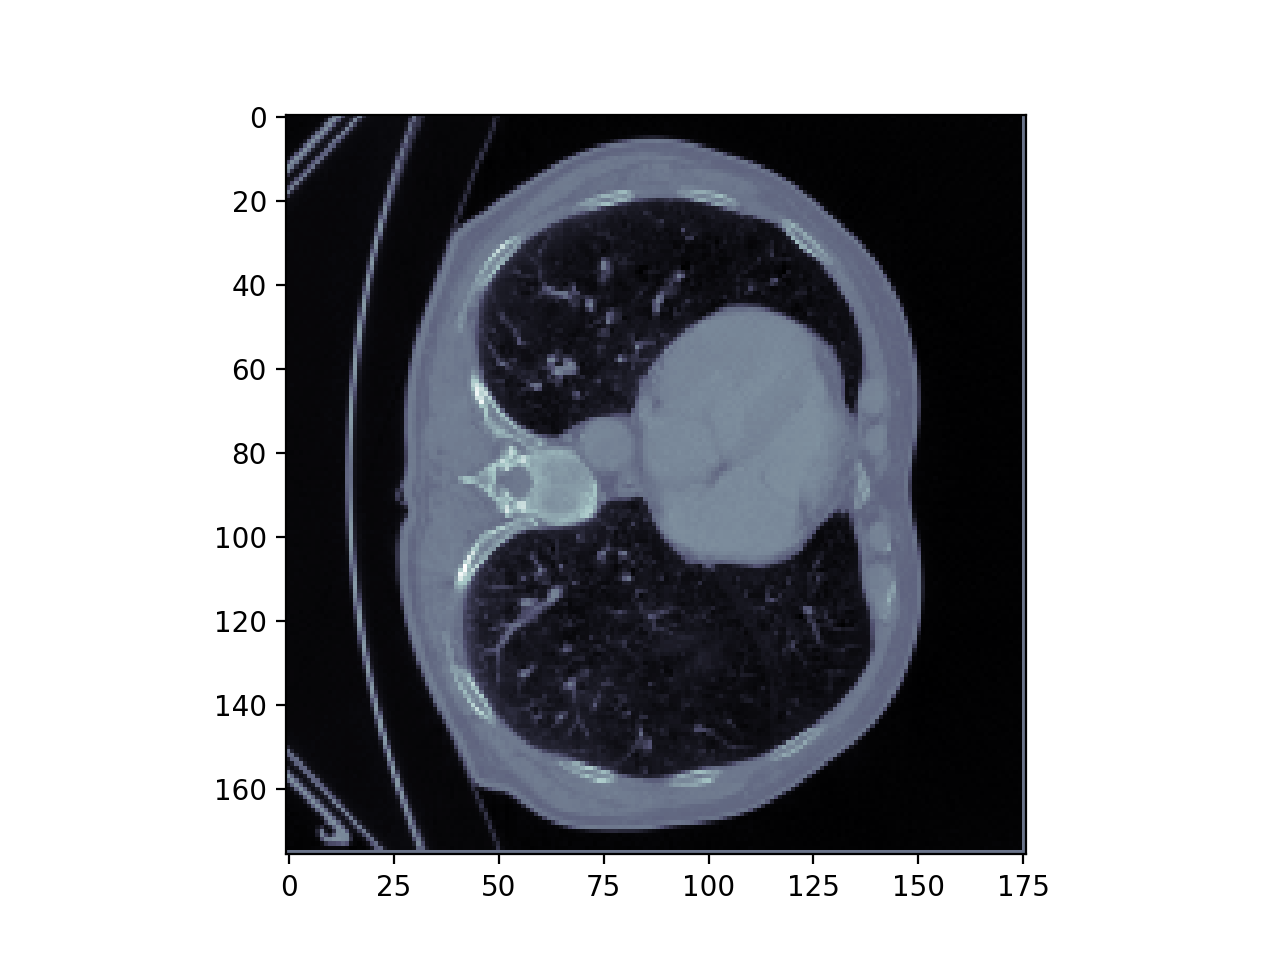

In [7]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(ct.shape[2]):  # Axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5)
    # plt.axis("off")
    camera.snap()  # Store the current slice
# plt.tight_layout()
animation = camera.animate()  # Create the animation
# 

## Train

In [ ]:
from pathlib import Path

import torchio as tio
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt

from model import UNet

## Dataset Creation

In [8]:
def change_img_to_label_path(path):
    """
    Replace data with mask to get the masks
    """
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [ ]:
path = Path("Task03_Liver_rs/imagesTr/")
subjects_paths = list(path.glob("liver_*"))
subjects = []

for subject_path in subjects_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"CT":tio.ScalarImage(subject_path), "Label":tio.LabelMap(label_path)})
    subjects.append(subject)

In [15]:
for subject in subjects:
    assert subject["CT"].orientation == ("R", "A", "S")

In [16]:
# Augmentation
process = tio.Compose([
            tio.CropOrPad((256, 256, 200)),
            tio.RescaleIntensity((-1, 1))
            ])


augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))


val_transform = process
train_transform = tio.Compose([process, augmentation])

Define the train and validation dataset. We use 105 subjects for training and 13 for testing.
In order to help the segmentation network learn, we use the LabelSampler with p=0.2 for background, p=0.3 for liver and p=0.5 for liver tumors with a patch size of ().

定义训练和验证数据集。我们使用 105 个科目进行训练，13 个科目进行测试。 为了帮助分割网络学习，我们使用 LabelSampler，p=0.2 作为背景，p=0.3 用于肝脏，p=0.5 用于patch大小为 () 的肝脏肿瘤。

In [17]:
train_dataset = tio.SubjectsDataset(subjects[:105], transform=train_transform)
val_dataset = tio.SubjectsDataset(subjects[105:], transform=val_transform)

sampler = tio.data.LabelSampler(patch_size=96, label_name="Label", label_probabilities={0:0.2, 1:0.3, 2:0.5})
#sampler = tio.data.UniformSampler(patch_size=96)

Create the queue to draw patches from.
The tio.Queue accepts a SubjectsDataset, a max_length argument describing the the number of patches that can be stored, the number of patches to draw from each subject, a sampler and the number of workers:

创建队列以从中绘制patch。tio.Queue 接受一个 SubjectsDataset，一个描述可以存储的补丁数量的 max_length 参数，从每个主题中抽取的补丁数量，一个采样器和工作人员的数量：

In [18]:
train_patches_queue = tio.Queue(
     train_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )

val_patches_queue = tio.Queue(
     val_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=2,
    )

In [ ]:
# Define train and val loader
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_patches_queue, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_patches_queue, batch_size=batch_size, num_workers=0)

In [ ]:
# Create the Segmentation model.
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        # You can obtain the raw volume arrays by accessing the data attribute of the subject
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # You can obtain the raw volume arrays by accessing the data attribute of the subject
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Val Loss", loss)
        self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss

    
    def log_images(self, img, pred, mask, name):
        
        results = []
        pred = torch.argmax(pred, 1) # Take the output with the highest value
        axial_slice = 50  # Always plot slice 50 of the 96 slices
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][:,:,axial_slice]==0, mask[0][:,:,axial_slice])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][:,:,axial_slice]==0, pred[0][:,:,axial_slice])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)

            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]

In [ ]:
# Instanciate the model
model = Segmenter()

In [ ]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

In [ ]:
# Create the trainer
gpus = 1 
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=100)

In [ ]:
# Train the model.
trainer.fit(model, train_loader, val_loader)

## Evaluation

In [ ]:
from IPython.display import HTML
from celluloid import Camera

In [ ]:
# Load the model and place it on the gpu
model = Segmenter.load_from_checkpoint("/weights/epoch=97-step=25773.ckpt")
model = model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

Patch Aggregation
The model was trained in a patch wise manner as the full volumes are too large to be placed on a typical GPU. But we still want to get a result for the whole volume.
torchio helps us doing so by performing Patch Aggregation

Patch aggregation splits the image into patches, then compute the segmentation for each patch and finally merge the predictions into the prediction for the full volume.

The pipeline is as follows:

Define the GridSampler(subject, patch_size, patch_overlap) responsible for dividing the volume into patches. Each patch is defined by its location accesible via tio.LOCATION
Define the GridAggregator(grid_sampler) which merges the predicted patches back together
Compute the prediction on the patches and aggregate them via aggregator.add_batch(pred, location)
Extract the full prediction via aggregator.get_output_tensor()
Additionally, we can leverage the DataLoader from pytorch to perform the prediction in a batch wise manner for a nice speed up

In [ ]:
# Select a validation subject and extract the images and segmentation for evaluation
IDX = 4
mask = val_dataset[IDX]["Label"]["data"]
imgs = val_dataset[IDX]["CT"]["data"]

# GridSampler
grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8, 8, 8))

In [ ]:

# GridAggregator
aggregator = tio.inference.GridAggregator(grid_sampler)

In [ ]:
# DataLoader for speed up
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)

In [ ]:
# Prediction
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch['CT']["data"].to(device)  # Get batch of patches
        locations = patches_batch[tio.LOCATION]  # Get locations of patches
        pred = model(input_tensor)  # Compute prediction
        aggregator.add_batch(pred, locations)  # Combine predictions to volume

In [ ]:
# Extract the volume prediction
output_tensor = aggregator.get_output_tensor()

In [ ]:
# Visualize the prediction
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[3], 2):  # axial view
    plt.imshow(imgs[0,:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(pred[:,:,i]==0, pred[:,:,i])
    label_mask = np.ma.masked_where(mask[0,:,:,i]==0, mask[0,:,:,i])
    plt.imshow(mask_, alpha=0.1, cmap="autumn")
    plt.imshow(label_mask, alpha=0.5, cmap="jet")  

    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

In [ ]:
HTML(animation.to_html5_video())  # convert the animation to a video